In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

%matplotlib inline

# This dictionary will be used to record model performance on validation data so I can later choose the best model. I'm sure there's a better way of doing this.
model_dict = {}

# EDA

In [2]:
df = pd.read_csv("/kaggle/input/playground-series-s3e10/train.csv")
df.drop(columns=['id'], inplace=True)
df.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [3]:
df.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076,0.093285
std,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110,0.290833
min,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976,0.000000
25%,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136,0.000000
50%,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375,0.000000
75%,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290,0.000000
max,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837,1.000000


In [4]:
df.Class.value_counts()

0    106597
1     10967
Name: Class, dtype: int64

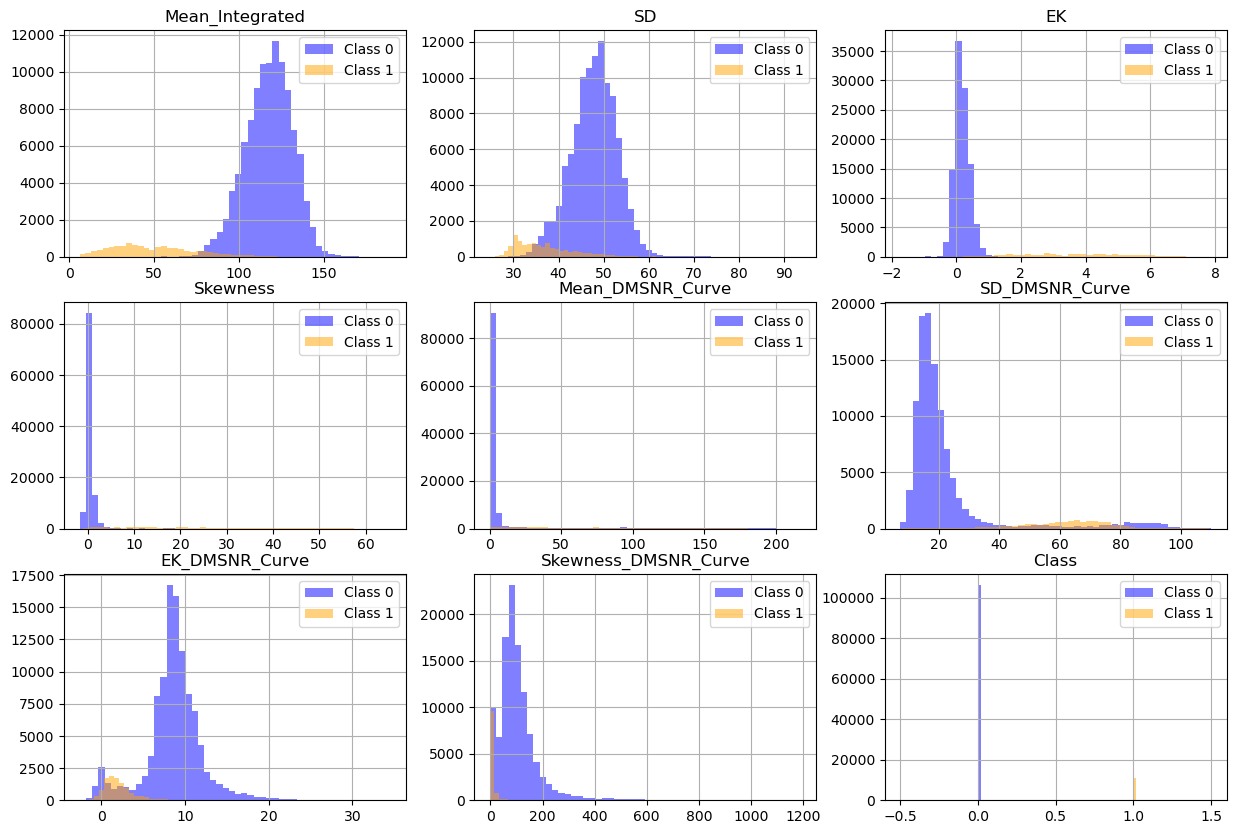

In [5]:
# https://www.kaggle.com/code/ndeperrois/sklearn-for-newbies-logistic-reg-random-f-etc
# Plot histograms of each feature colored by their 'Class' labels
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

colors = {0: 'blue', 1: 'orange'}

for idx, feature in enumerate(df.columns):
    row_idx = idx // 3
    col_idx = idx % 3
    for cls in [0, 1]:
        df[df['Class'] == cls][feature].hist(ax=axs[row_idx, col_idx], bins=50, alpha=0.5, color=colors[cls], label=f"Class {cls}")
    axs[row_idx, col_idx].set_title(feature)
    axs[row_idx, col_idx].legend()
    
plt.show()

# Cleaning Data and Removing Outliers

In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the shape of the resulting dataframes
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

Training set shape: (94051, 9)
Validation set shape: (23513, 9)


In [7]:
def remove_outlier(train):
    outliers = train[
        (train['Class']==1)&
        (train['Mean_Integrated']>115)&
        (train['SD']>45)&
        (train['EK']<0.03)&
        (train['Skewness']<1)&
        (train['Mean_DMSNR_Curve']<20)
    ].index
    train.drop(outliers,inplace=True)
    train.reset_index()
    return train

train_df = remove_outlier(train_df)

In [8]:
X_train = np.array(train_df.drop('Class', axis=1))
y_train = np.array(train_df['Class'])

X_val = np.array(val_df.drop('Class', axis=1))
y_val = np.array(val_df['Class'])

# Actual model training

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter=10000)

# Fit the model on the training data
logistic_reg.fit(X_train, y_train)

# Predict on the validation data 
y_pred_train = logistic_reg.predict(X_train)
y_pred_val = logistic_reg.predict(X_val)

# Evaluate the model using accuracy score
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training accuracy: 0.9892500558231523
Validation accuracy: 0.9896652915408497


In [10]:
model_dict["Logistic Regression"] = val_accuracy

### Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred_train, y_train)
confusion_matrix(y_pred_val, y_val)

array([[21258,   183],
       [   60,  2012]])

### F1 Score

In [12]:
from sklearn.metrics import f1_score
print(f"Training F1 score: {f1_score(y_pred_train, y_train)}")
print(f"Validation F1 score: {f1_score(y_pred_val, y_val)}")

Training F1 score: 0.9406794578419292
Validation F1 score: 0.9430513241153036


## Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

y_probas_forest_train = forest_clf.predict_proba(X_train)
y_pred_forest_train = (y_probas_forest_train[:, 1] >= 0.5).astype(int)

y_probas_forest_val = forest_clf.predict_proba(X_val)
y_pred_forest_val = (y_probas_forest_val[:, 1] >= 0.5).astype(int)

print(f"Training F1 score (rdf): {f1_score(y_pred_forest_train, y_train)}")
print(f"Validation F1 score (rdf): {f1_score(y_pred_forest_val, y_val)}")

train_accuracy = accuracy_score(y_train, y_pred_forest_train)
val_accuracy = accuracy_score(y_val, y_pred_forest_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training F1 score (rdf): 1.0
Validation F1 score (rdf): 0.9479553903345725
Training accuracy: 1.0
Validation accuracy: 0.9904733551652277


In [14]:
model_dict["Random Forest Classifier"] = val_accuracy

## MLP Classifier

In [15]:
from sklearn.neural_network import MLPClassifier

# Create a shallow neural network with one hidden layer of 10 neurons
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)

# Train the classifier on the training data
clf.fit(X_train, y_train)

y_pred_mlp_train = clf.predict(X_train)

y_pred_mlp_val = clf.predict(X_val)
print(f"Training F1 score (mlp): {f1_score(y_pred_mlp_train, y_train)}")
print(f"Validation F1 score (mlp): {f1_score(y_pred_mlp_val, y_val)}")

train_accuracy = accuracy_score(y_train, y_pred_mlp_train)
val_accuracy = accuracy_score(y_val, y_pred_mlp_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training F1 score (mlp): 0.9358102314947128
Validation F1 score (mlp): 0.9339428571428572
Training accuracy: 0.9880591619084075
Validation accuracy: 0.9877089269765662


In [16]:
model_dict["MLP Classifier"] = val_accuracy

## XGBoost, CatBoost and LightGBM

In [17]:
# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import log_loss

In [18]:
# XGBoost

xgb_param = {
    'n_estimators':700,
    'learning_rate':0.01,
    'max_depth':7,
    'subsample':0.8,
}

xgb = XGBClassifier(**xgb_param).fit(X_train, y_train)

In [19]:
y_xgb_pred = xgb.predict(X_train)
y_xgb_pred_val = xgb.predict(X_val)

print(f"Training F1 score (XGBoost): {f1_score(y_xgb_pred, y_train)}")
print(f"Validation F1 score (XGBoost): {f1_score(y_xgb_pred_val, y_val)}")

train_accuracy = accuracy_score(y_train, y_xgb_pred)
val_accuracy = accuracy_score(y_val, y_xgb_pred_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training F1 score (XGBoost): 0.967027872747291
Validation F1 score (XGBoost): 0.9503710575139147
Training accuracy: 0.9939498335938414
Validation accuracy: 0.9908986518096372


In [20]:
model_dict["XGBoost"] = val_accuracy

In [21]:
# LightGBM

lgbm_param = {
    'n_estimators':700,
    'learning_rate':0.01,
    'max_depth':7,
    'num_leaves':15,
}

lgbm = LGBMClassifier(**lgbm_param).fit(X_train, y_train)

In [22]:
y_lgbm_pred = lgbm.predict(X_train)
y_lgbm_pred_val = lgbm.predict(X_val)

print(f"Training F1 score (LGBM): {f1_score(y_lgbm_pred, y_train)}")
print(f"Validation F1 score (LGBM): {f1_score(y_lgbm_pred_val, y_val)}")

train_accuracy = accuracy_score(y_train, y_lgbm_pred)
val_accuracy = accuracy_score(y_val, y_lgbm_pred_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training F1 score (LGBM): 0.9553763128880636
Validation F1 score (LGBM): 0.9499768411301528
Training accuracy: 0.9918232373175114
Validation accuracy: 0.9908135924807553


In [23]:
model_dict["LightGBM"] = val_accuracy

In [24]:
# CatBoost

cat_param = {
    'learning_rate':0.02,
    'iterations':5000,
    'verbose':False,
    'early_stopping_rounds':1000,
    'max_depth':3,
    'loss_function':'Logloss',
    'eval_metric':'Logloss',
    'random_seed':39,
    'use_best_model':True
}

cat = CatBoostClassifier(**cat_param).fit(X_train, y_train, eval_set=[(X_val, y_val)])

In [25]:
y_cat_pred = cat.predict(X_train)
y_cat_pred_val = cat.predict(X_val)

print(f"Training F1 score (Cat): {f1_score(y_cat_pred, y_train)}")
print(f"Validation F1 score (Cat): {f1_score(y_cat_pred_val, y_val)}")

train_accuracy = accuracy_score(y_train, y_cat_pred)
val_accuracy = accuracy_score(y_val, y_cat_pred_val)
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")

Training F1 score (Cat): 0.9583042973286876
Validation F1 score (Cat): 0.9495466170657988
Training accuracy: 0.9923655193679756
Validation accuracy: 0.9907710628163143


In [26]:
model_dict["CatBoost"] = val_accuracy

# Finding Best Model

In [27]:
# XGBoost

score = max(model_dict.values())
list(model_dict.keys())[list(model_dict.values()).index(score)]

'XGBoost'

# Submission

In [28]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e10/test.csv")
X_test = np.array(test_df.drop(columns=['id']))

In [29]:
final_preds = xgb.predict(X_test)

In [30]:
sample_submission = test_df.id.to_frame()

sample_submission.set_index(sample_submission.id)
sample_submission["Class"] = final_preds

sample_submission.head()

,id,Class
0,117564,0
1,117565,0
2,117566,0
3,117567,0
4,117568,0


In [31]:
# Save to csv
sample_submission.to_csv("submission.csv", index=None)

In [32]:
# Make sure file is ok

submission = pd.read_csv("submission.csv")
submission.head()

,id,Class
0,117564,0
1,117565,0
2,117566,0
3,117567,0
4,117568,0
